# Naive Bayes Multinomial
## === Task ===
1) Learn about TFidVectorizer and replace CountVectorizer with TfidfVectorizer (Explanation Provided in the Lecture) 2) Put Multinomial Naive Classification into a class that can transform the data, fit the model and do prediction.

2) In the class, allow users to choose whether to use CountVectorizer or TFIDVectorizer to transform the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [3]:
X_train = train.data
X_test = test.data
y_train = train.target
y_test = test.target

## So we have 4 topics that could be the category of text we would like to classify

In [4]:
np.unique(train.target_names)

array(['comp.graphics', 'sci.space', 'soc.religion.christian',
       'talk.religion.misc'], dtype='<U22')

In [5]:
class NaiveBayesMultinomial:

  def __init__(self, method = 'CountVectorizer'):
    pass



  def transform(self, train_data, test_data, method = 'CountVectorizer'):
    self.method = method

    if self.method == 'CountVectorizer':
      from sklearn.feature_extraction.text import CountVectorizer
      vectorizer = CountVectorizer()
      vectorized_X_train = vectorizer.fit_transform(train_data)
      vectorized_X_test = vectorizer.transform(test_data).toarray() #vectorizer gives us a sparse matrix; convert back to dense matrix

      assert vectorized_X_train.shape[1] == vectorized_X_test.shape[1], 'Mismatched classes between X_train and X_test after vectorization'

      self.vectorized_X_train = vectorized_X_train
      self.vectorized_X_test = vectorized_X_test

    elif self.method == 'TfidfVectorizer':
      from sklearn.feature_extraction.text import TfidfVectorizer
      vectorizer = TfidfVectorizer()
      vectorized_X_train = vectorizer.fit_transform(train_data)
      vectorized_X_test = vectorizer.transform(test_data).toarray() 

      assert vectorized_X_train.shape[1] == vectorized_X_test.shape[1], 'Mismatched classes between X_train and X_test after vectorization'

      self.vectorized_X_train = vectorized_X_train
      self.vectorized_X_test = vectorized_X_test
    
    else:
      print("The method can be either 'CountVectorizer' or 'TfidfVectorizer' !")


  def fit(self, y_train):
    assert self.vectorized_X_train.shape[0] == y_train.shape[0], 'Mismatched sample between X_train and y_train'

    m = self.vectorized_X_train.shape[0]
    n = self.vectorized_X_train.shape[1]
    k = len(np.unique(y_train))
    classes = np.unique(y_train)

    classCount = np.zeros(k)
    likelihoodClass = np.zeros((k, n))

    for each_class in range(k):
      eachClassX = self.vectorized_X_train[y_train == each_class]
      classCount[each_class] = eachClassX.shape[0]
      nominator = np.sum(eachClassX ,axis = 0) + 1
      denominator = np.sum(nominator)
      likelihood = nominator / denominator
      likelihoodClass[each_class, :] = likelihood


    priorPerClass = [each_class / np.sum(classCount) for each_class in classCount]
    assert np.sum(priorPerClass) == 1

    self.m = m
    self.n = n
    self.k = k
    self.classes = classes
    self.classCount = classCount
    self.priorPerClass = priorPerClass
    self.likelihoodClass = likelihoodClass


  def predict(self):

    assert self.vectorized_X_test.shape[1] == self.likelihoodClass.T.shape[0], 'mismatched shape for dot product'
    output = np.log(self.priorPerClass) +  np.dot(self.vectorized_X_test, np.log(self.likelihoodClass.T))

    assert output.shape == (self.vectorized_X_test.shape[0], self.k), 'Wrong output shape, must be in m by k'
    arg_max = np.argmax(output, axis =1)


    self.rawPredicted = output
    return arg_max



  def createReport(self, y_true, y_pred):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import average_precision_score, classification_report
    ytrue_binarized= label_binarize(y_true, classes = self.classes)
    yhat_binarized = label_binarize(y_pred, classes = self.classes)
    for each_class in range(self.k):
      print(f'average precision score of class {each_class}: {average_precision_score(ytrue_binarized[:, each_class], yhat_binarized[:, each_class])}')
    
    print()
    print(classification_report(y_true, y_pred))

  # def createVisualization(self, y_true, y_pred):
  #   from sklearn.metrics import confusion_matrix
  #   plot = confusion_matrix(y_true, y_pred)
  #   sns.heatmap(plot, cmap ='coolwarm', annot = True)
  #   plt.xlabel('true class')
  #   plt.xlabel('true class')



--- 

## Test the model wiht CountVectorizer

In [6]:
NBMcount = NaiveBayesMultinomial()

In [7]:
NBMcount.transform(X_train, X_test, method = 'CountVectorizer')

In [8]:
print(NBMcount.vectorized_X_test.shape)
print(NBMcount.vectorized_X_train.shape)

(1432, 35329)
(2153, 35329)


In [9]:
NBMcount.fit(y_train)

In [10]:
print(NBMcount.classes)
print(NBMcount.priorPerClass)

[0 1 2 3]
[0.2712494194147701, 0.2754296330701347, 0.2782164421737111, 0.1751045053413841]


In [11]:
count_yhat = NBMcount.predict()

In [12]:
NBMcount.createReport(y_true = y_test, y_pred = count_yhat)

average precision score of class 0: 0.9152047938418233
average precision score of class 1: 0.9069918620723723
average precision score of class 2: 0.8429395016564877
average precision score of class 3: 0.7277310085946386

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       389
           1       0.94      0.96      0.95       394
           2       0.87      0.95      0.91       398
           3       0.92      0.74      0.82       251

    accuracy                           0.92      1432
   macro avg       0.92      0.90      0.91      1432
weighted avg       0.92      0.92      0.92      1432



## Test the model with TfidtVectorizer

In [13]:
NBMtfid = NaiveBayesMultinomial()

In [14]:
NBMtfid.transform(X_train, X_test, method = 'TfidfVectorizer')

In [15]:
print(NBMtfid.vectorized_X_test.shape)
print(NBMtfid.vectorized_X_train.shape)

(1432, 35329)
(2153, 35329)


In [16]:
NBMtfid.fit(y_train)

In [17]:
tfidf_yhat = NBMtfid.predict()

In [18]:
print(NBMtfid.classes)
print(NBMtfid.priorPerClass)

[0 1 2 3]
[0.2712494194147701, 0.2754296330701347, 0.2782164421737111, 0.1751045053413841]


In [19]:
NBMtfid.createReport(y_true= y_test, y_pred = tfidf_yhat)

average precision score of class 0: 0.888341920518241
average precision score of class 1: 0.8744630809734135
average precision score of class 2: 0.6122064043881043
average precision score of class 3: 0.332994836297269

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       389
           1       0.92      0.92      0.92       394
           2       0.62      0.98      0.76       398
           3       1.00      0.19      0.32       251

    accuracy                           0.80      1432
   macro avg       0.88      0.75      0.73      1432
weighted avg       0.86      0.80      0.77      1432



In [20]:
## CO

## Confusion Matrix comparing between CountVectorizer and TfidfVectorizer

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

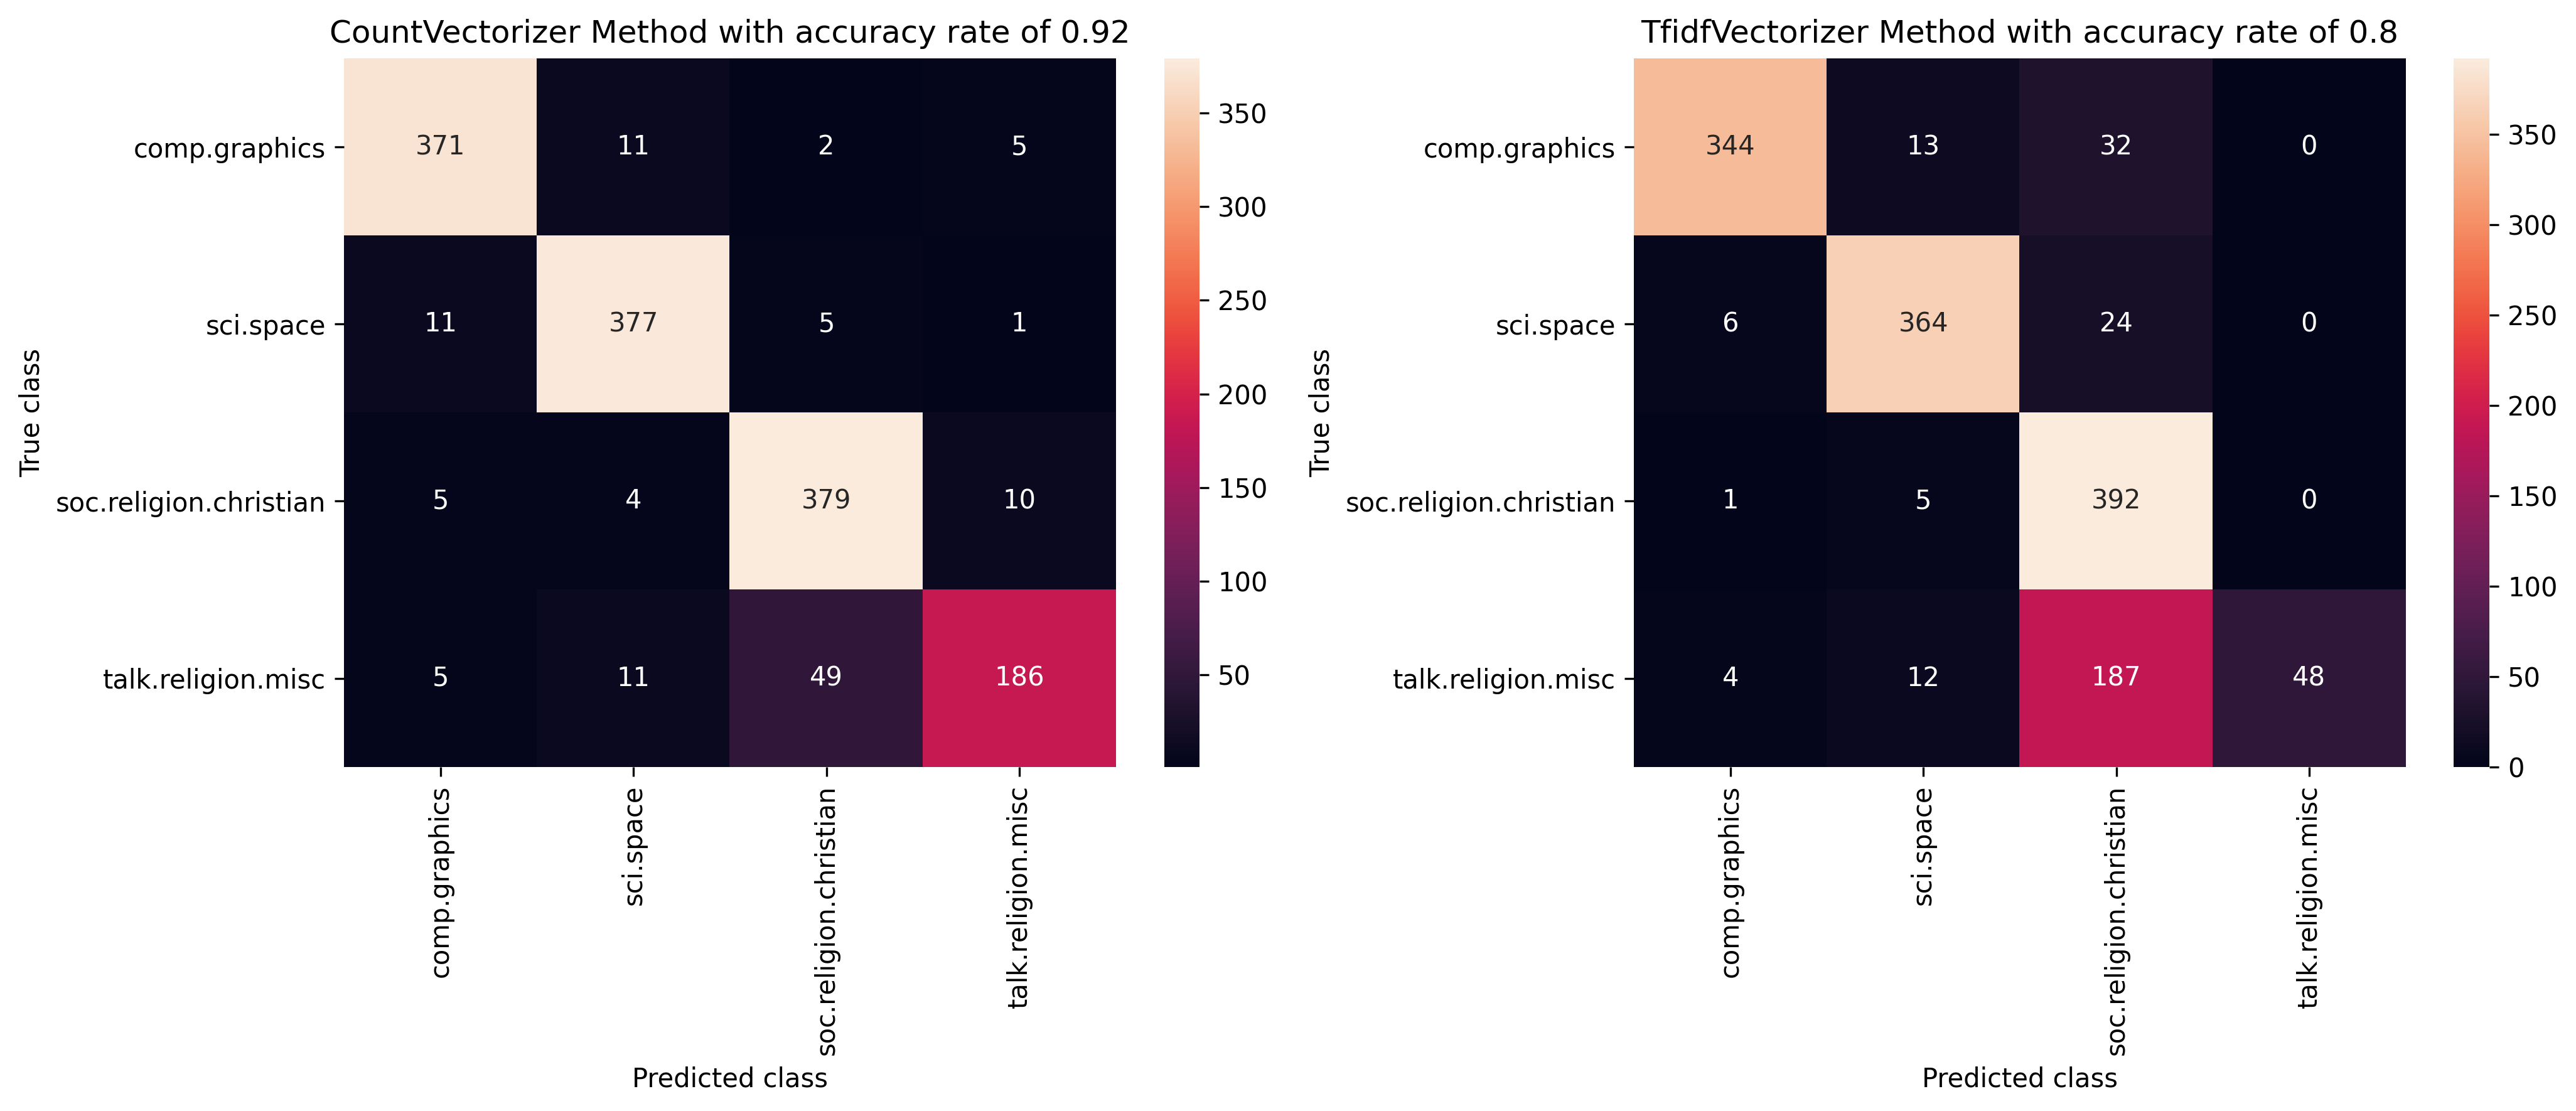

In [22]:
fig, axes = plt.subplots(1,2 , figsize = (14,6), dpi = 300)

sns.heatmap(confusion_matrix(y_true= y_test, y_pred = count_yhat) ,
            annot = True, fmt = 'd', xticklabels = train.target_names,
            yticklabels = train.target_names, ax = axes[0])

sns.heatmap(confusion_matrix(y_true= y_test, y_pred = tfidf_yhat) ,
            annot = True, fmt = 'd', xticklabels = train.target_names,
            yticklabels = train.target_names, ax = axes[1])



axes[0].set_title(f'CountVectorizer Method with accuracy rate of {round(accuracy_score(y_true= y_test, y_pred = count_yhat),2)}')
axes[0].set_xlabel('Predicted class')
axes[0].set_ylabel('True class')


axes[1].set_title(f'TfidfVectorizer Method with accuracy rate of {round(accuracy_score(y_true= y_test, y_pred = tfidf_yhat),2)}')
axes[1].set_xlabel('Predicted class')
axes[1].set_ylabel('True class')

fig.tight_layout()

## Summary


*   CountVectorizer yields higher accuracy score at 92%, compared to 80% from TfidfVectorizer method
*   There is significant precision and recall score drop in class 2 and 3 (soc.religion.christian and talk.religion.misc. respectively, as these classes involved the overlapping topics: religion. The redundancy may weaken the model to identify which documents belong to which class



---